In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from random import randint
from PIL import Image
import cv2
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Input, concatenate, Dropout, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.vgg16 import *
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
data_dir = Path('D:/deep learning/CamVid/')
list(data_dir.iterdir())
        

[WindowsPath('D:/deep learning/CamVid/class_dict.csv'),
 WindowsPath('D:/deep learning/CamVid/model'),
 WindowsPath('D:/deep learning/CamVid/test'),
 WindowsPath('D:/deep learning/CamVid/test_labels'),
 WindowsPath('D:/deep learning/CamVid/train'),
 WindowsPath('D:/deep learning/CamVid/train_labels'),
 WindowsPath('D:/deep learning/CamVid/val'),
 WindowsPath('D:/deep learning/CamVid/val_labels')]

In [3]:
def tree(directory):
    print(f'+{directory}')
    for path in sorted(directory.rglob('*')):
        depth = len(path.relative_to(directory).parts)
        spacer = ' '*depth
        print(f'{spacer}+{path.name}')

tree(data_dir)

+D:\deep learning\CamVid
 +class_dict.csv
 +model
 +test
  +0001TP_006690.png
  +0001TP_006720.png
  +0001TP_006750.png
  +0001TP_006780.png
  +0001TP_006810.png
  +0001TP_006840.png
  +0001TP_006870.png
  +0001TP_006900.png
  +0001TP_006930.png
  +0001TP_006960.png
  +0001TP_006990.png
  +0001TP_007020.png
  +0001TP_007050.png
  +0001TP_007080.png
  +0001TP_007110.png
  +0001TP_007140.png
  +0001TP_007170.png
  +0001TP_007200.png
  +0001TP_007230.png
  +0001TP_007260.png
  +0001TP_007290.png
  +0001TP_007320.png
  +0001TP_007350.png
  +0001TP_007380.png
  +0001TP_007410.png
  +0001TP_007440.png
  +0001TP_007470.png
  +0001TP_007500.png
  +0001TP_007530.png
  +0001TP_007560.png
  +0001TP_007590.png
  +0001TP_007620.png
  +0001TP_007650.png
  +0001TP_007680.png
  +0001TP_007710.png
  +0001TP_007740.png
  +0001TP_007770.png
  +0001TP_007800.png
  +0001TP_007830.png
  +0001TP_007860.png
  +0001TP_007890.png
  +0001TP_007920.png
  +0001TP_007950.png
  +0001TP_007980.png
  +0001TP_008010.pn

In [4]:


train_imgs = list((data_dir/ 'train').glob("*.png"))
train_labels = list((data_dir/ 'train_labels').glob("*.png"))

valid_imgs = list((data_dir/ 'val').glob("*.png"))
valid_labels = list((data_dir/ 'val_labels').glob("*.png"))

test_imgs = list((data_dir/ 'test').glob("*.png"))
test_labels = list((data_dir/ 'test_labels').glob("*.png"))

print(len(train_imgs))
print(len(train_labels))
print(len(test_imgs))
print(len(test_labels))
print(len(valid_imgs))
print(len(valid_labels))


369
369
232
232
100
100


In [5]:
assert len(train_imgs) == len(train_labels)
assert len(valid_imgs) == len(valid_labels)
assert len(test_imgs) == len(test_labels)

sorted(train_imgs),sorted(train_labels), sorted(valid_imgs),sorted(valid_labels),sorted(test_imgs),sorted(test_labels);

In [6]:
for img in train_imgs:
    assert data_dir/ 'train_labels' / (img.stem+'_L.png') in train_labels
    
for img in valid_imgs:
    assert data_dir/ 'val_labels' / (img.stem+'_L.png') in valid_labels

for img in test_imgs:
    assert data_dir/ 'test_labels' / (img.stem+'_L.png') in test_labels
    

In [7]:
def img_pairs(imgs,label,data):
    img_pairs =[]
    for img in imgs:
        img_pairs.append((img,data/ label/ (img.stem+'_L.png')))
        
    return img_pairs

In [8]:
train_pairs = img_pairs(train_imgs,'train_labels',data_dir)
val_pairs = img_pairs(valid_imgs, 'val_labels',data_dir)
test_pairs = img_pairs(test_imgs,'test_labels', data_dir)

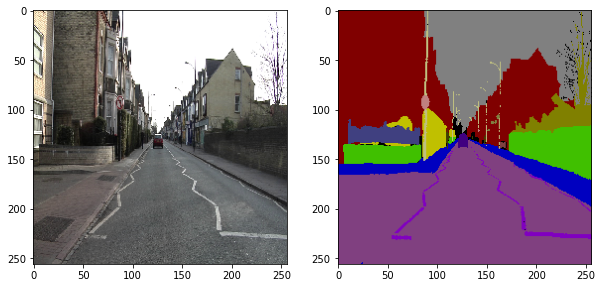

In [9]:
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from random import choice
temp = choice(train_pairs)
img = img_to_array(load_img(temp[0],target_size=(256,256)))
mask = img_to_array(load_img(temp[1],target_size=(256,256)))

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img/255)
plt.subplot(122)
plt.imshow(mask/255)

In [10]:
class_map_csv = pd.read_csv(data_dir/ 'class_dict.csv')

In [11]:
class_map = []
for index, item in class_map_csv.iterrows():
    class_map.append(np.array([item['r'],item['g'],item['b']]))
    

In [12]:
len(class_map)

32

In [13]:
def assert_map_range(mask,class_map):
    mask = mask.astype(np.uint8)
    for j in range(256):
        for k in range(256):
            assert mask[j][k] in class_map, tuple(mask[j][k])

In [14]:
def _2d_label(mask,class_map):
    mask = mask.astype(np.uint8)
    label = np.zeros(mask.shape[:2],dtype =np.uint8)
    
    for i, rgb in enumerate(class_map):
        label[(mask==rgb).all(axis=2)] = i
        
    return label

In [15]:
sample_label = _2d_label(mask,class_map)
np.unique(sample_label,return_counts =True)

(array([ 4,  5,  8,  9, 10, 12, 14, 16, 17, 19, 20, 21, 26, 29, 30, 31],
       dtype=uint8),
 array([16306,   126,   492,  1199,   836,    35,    33,    57, 23253,
         3133,   101, 11985,  1866,  1118,   480,  4516], dtype=int64))

In [16]:
from tensorflow.keras.utils import to_categorical, Sequence
class DataGenerator(Sequence):
    def __init__(self,pair,class_map,batch_size=8,dim=(256,256,3),shuffle=True):
        self.pair = pair
        self.class_map = class_map
        self.batch_size= batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.on_epoch_end()
    def __len__(self):
        return int(np.floor(len(self.pair)/ self.batch_size))
    
    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        list_ids_temp = [i for i in indexes]
        X,y = self.__data_generation(list_ids_temp)
        
        return X,y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.pair))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        
    def __data_generation(self,list_ids_temp):
        batch_imgs = list()
        batch_labels = list()
        
        for i in list_ids_temp:
            img = load_img(self.pair[i][0], target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)
            
            label = load_img(self.pair[i][1],target_size=self.dim)
            label = img_to_array(label)
            label = _2d_label(label,self.class_map)
            label = to_categorical(label,num_classes =32)
            batch_labels.append(label)
            
        return np.array(batch_imgs),np.array(batch_labels)

In [17]:
train_generator = DataGenerator(train_pairs+test_pairs,class_map,batch_size=4,dim=(256,256,3),shuffle=True)
train_steps = train_generator.__len__()
print(train_steps)

150


In [18]:
dX,y = train_generator.__getitem__(1)

In [19]:
print(dX.shape, y.shape)

(4, 256, 256, 3) (4, 256, 256, 32)


In [20]:
val_generator = DataGenerator(val_pairs,class_map,batch_size=4,dim=(256,256,3),shuffle=True)
val_steps = val_generator.__len__()
print(val_steps)

25


In [21]:
n_filters =64
strides=(2,2)
n_classes = 32

def conv(n_filters,kernel_size,padding='same'):
    return Conv2D(n_filters,kernel_size=kernel_size,padding='same',kernel_initializer='he_normal',activation='relu')

def conv2d_transpose(n_filters,kernel_size,strides=strides,padding='same'):
    return Conv2DTranspose(n_filters,kernel_size=kernel_size,strides=strides,padding='same',activation='relu',kernel_initializer='he_normal')


def U_Net():
    input_lr = Input(shape=(256,256,3))
    
    c1 = conv(n_filters*1,kernel_size=(3,3),padding='same')(input_lr) #64
    c2 = conv(n_filters*1,kernel_size=(3,3),padding='same')(c1)
    p1 = MaxPooling2D(pool_size=(2,2))(c2)
    
    c3 = conv(n_filters*2,kernel_size=(3,3),padding='same')(p1)  #128
    c4 = conv(n_filters*2,kernel_size=(3,3),padding='same')(c3)
    p2 = MaxPooling2D(pool_size=(2,2))(c4) 
    
    c5 = conv(n_filters*4,kernel_size=(3,3),padding='same')(p2)  #256
    c6 = conv(n_filters*4,kernel_size=(3,3),padding='same')(c5)
    p3 = MaxPooling2D(pool_size=(2,2))(c6)
    
    c7 = conv(n_filters*8,kernel_size=(3,3),padding='same')(p3)  #512
    c8 = conv(n_filters*8,kernel_size=(3,3),padding='same')(c7)
    p4 = MaxPooling2D(pool_size=(2,2))(c8)
    
    c9 = conv(n_filters*16,kernel_size=(3,3),padding='same')(p4) #1024
    c10 = conv(n_filters*16,kernel_size=(3,3),padding='same')(c9)
    
    
    u5 = conv2d_transpose(n_filters*8,kernel_size=(3,3),strides=strides,padding='same')(c10)
    u5 = concatenate([u5,c8])
    c11 = conv(n_filters*8,kernel_size=(3,3),padding='same')(u5)
    
    u4 = conv2d_transpose(n_filters*4,kernel_size=(3,3),strides=strides,padding='same')(c11)
    u4 = concatenate([u4,c6])
    c12 = conv(n_filters*4,kernel_size=(3,3),padding='same')(u4)
    
    u3 = conv2d_transpose(n_filters*2,kernel_size=(3,3),strides=strides,padding='same')(c12)
    u3 = concatenate([u3,c4])
    c13 = conv(n_filters*2,kernel_size=(3,3),padding='same')(u3)
    
    u2 = conv2d_transpose(n_filters*1,kernel_size=(3,3),strides=strides,padding='same')(c13)
    u2 = concatenate([u2,c2])
    c14 = conv(n_filters*1,kernel_size=(3,3),padding='same')(u2)
    
    output = Conv2D(filters=n_classes,kernel_size=(1,1),activation='softmax',padding='same')(c14)
    
    model = Model(inputs=[input_lr],outputs=[output])
    return model

In [22]:
model = U_Net()

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [24]:
def iou_coef(y_true,y_pred,smooth=1):
    intersection = K.sum(K.abs(y_true*y_pred),axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    
    iou = K.mean((intersection +smooth)/(union-smooth),axis=0)
    
    return iou

In [25]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',iou_coef])

In [26]:
es = EarlyStopping(mode='max',monitor='val_accuracy',patience=10,verbose=1)
mc = ModelCheckpoint(mode='max',monitor='val_accuracy',filepath ='D:/deep learning/CamVid/model/U-Net.h5',save_best_only='True',verbose=1)
rl = ReduceLROnPlateau(monitor ='val_accuracy',factor=0.1,patience=10,verbose=1,mode='max',min_lr=1e-5)

In [27]:
hist = model.fit(train_generator,steps_per_epoch=train_steps,epochs=100,validation_data=val_generator,validation_steps=val_steps,callbacks=[mc,es,rl])

Epoch 1/100
150/150 [==============================] - ETA: 0s - loss: 1.6953 - accuracy: 0.5080 - iou_coef: 0.2315
Epoch 00001: val_accuracy improved from -inf to 0.67944, saving model to D:/deep learning/CamVid/model/U-Net.h5
150/150 [==============================] - 150s 998ms/step - loss: 1.6953 - accuracy: 0.5080 - iou_coef: 0.2315 - val_loss: 1.0892 - val_accuracy: 0.6794 - val_iou_coef: 0.3998 - lr: 0.0010
Epoch 2/100
150/150 [==============================] - ETA: 0s - loss: 1.0255 - accuracy: 0.6951 - iou_coef: 0.4103
Epoch 00002: val_accuracy improved from 0.67944 to 0.73563, saving model to D:/deep learning/CamVid/model/U-Net.h5
150/150 [==============================] - 149s 992ms/step - loss: 1.0255 - accuracy: 0.6951 - iou_coef: 0.4103 - val_loss: 0.9312 - val_accuracy: 0.7356 - val_iou_coef: 0.4348 - lr: 0.0010
Epoch 3/100
150/150 [==============================] - ETA: 0s - loss: 0.8027 - accuracy: 0.7682 - iou_coef: 0.5054
Epoch 00003: val_accuracy improved from 0.735

150/150 [==============================] - ETA: 0s - loss: 0.2725 - accuracy: 0.9145 - iou_coef: 0.7808
Epoch 00021: val_accuracy improved from 0.88785 to 0.89570, saving model to D:/deep learning/CamVid/model/U-Net.h5
150/150 [==============================] - 149s 993ms/step - loss: 0.2725 - accuracy: 0.9145 - iou_coef: 0.7808 - val_loss: 0.3669 - val_accuracy: 0.8957 - val_iou_coef: 0.7637 - lr: 0.0010
Epoch 22/100
150/150 [==============================] - ETA: 0s - loss: 0.2734 - accuracy: 0.9146 - iou_coef: 0.7811
Epoch 00022: val_accuracy did not improve from 0.89570
150/150 [==============================] - 148s 986ms/step - loss: 0.2734 - accuracy: 0.9146 - iou_coef: 0.7811 - val_loss: 0.3692 - val_accuracy: 0.8925 - val_iou_coef: 0.7496 - lr: 0.0010
Epoch 23/100
150/150 [==============================] - ETA: 0s - loss: 0.2610 - accuracy: 0.9179 - iou_coef: 0.7880
Epoch 00023: val_accuracy did not improve from 0.89570
150/150 [==============================] - 148s 987ms/ste

150/150 [==============================] - ETA: 0s - loss: 0.1154 - accuracy: 0.9594 - iou_coef: 0.8887
Epoch 00042: val_accuracy did not improve from 0.90666
150/150 [==============================] - 379s 3s/step - loss: 0.1154 - accuracy: 0.9594 - iou_coef: 0.8887 - val_loss: 0.4090 - val_accuracy: 0.9055 - val_iou_coef: 0.8029 - lr: 0.0010
Epoch 43/100
150/150 [==============================] - ETA: 0s - loss: 0.1115 - accuracy: 0.9606 - iou_coef: 0.8919
Epoch 00043: val_accuracy did not improve from 0.90666
150/150 [==============================] - 356s 2s/step - loss: 0.1115 - accuracy: 0.9606 - iou_coef: 0.8919 - val_loss: 0.4244 - val_accuracy: 0.9053 - val_iou_coef: 0.8055 - lr: 0.0010
Epoch 44/100
150/150 [==============================] - ETA: 0s - loss: 0.1124 - accuracy: 0.9601 - iou_coef: 0.8910
Epoch 00044: val_accuracy did not improve from 0.90666
150/150 [==============================] - 341s 2s/step - loss: 0.1124 - accuracy: 0.9601 - iou_coef: 0.8910 - val_loss: 0.

In [29]:
def make_predictions(model,img_path,shape):
    img = img_to_array(load_img(img_path, target_size=(256,256,3)))/255.
    img = np.expand_dims(img,axis=0)
    labels = model.predict(img)
    labels = np.argmax(labels[0],axis=2)
    return labels

In [31]:
img_mask = choice(val_pairs)
img = img_to_array(load_img(img_mask[0],target_size=(256,256,3)))
gt_label = img_to_array(load_img(img_mask[1],target_size=(256,256)))

pred_labels = make_predictions(model,img_mask[0],(256,256,3))
pred_labels.shape

(256, 256)

In [32]:
def form_colormap(prediction,mapping):
    h,w = prediction.shape
    color_label = np.zeros((h,w,3),dtype=np.uint8)
    color_label = mapping[prediction]
    color_label = color_label.astype(np.uint8)
    return color_label

In [36]:
pred_colored = form_colormap(pred_labels,np.array(class_map))

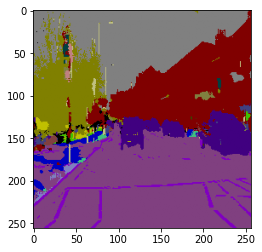

In [37]:
plt.imshow(pred_colored/255.)

In [41]:
print(len(valid_imgs))
val_pairs[1]

100


(WindowsPath('D:/deep learning/CamVid/val/0001TP_009060.png'),
 WindowsPath('D:/deep learning/CamVid/val_labels/0001TP_009060_L.png'))

In [44]:
predictions = []

for i in range(len(valid_imgs)):
    img_mask = val_pairs[i]
    img = img_to_array(load_img(img_mask[0],target_size=(256,256)))
    gt_img = img_to_array(load_img(img_mask[1],target_size=(256,256)))
    pred_label = make_predictions(model,img_mask[0],(256,256,3))
    
    pred_colored = form_colormap(pred_label, np.array(class_map))
    predictions.append(pred_colored)
    

In [50]:
predictions = np.asarray(predictions)

In [61]:
framesize=(256,256)
out_video = cv2.VideoWriter('D:/deep learning/CamVid/output_predictions1.avi',cv2.VideoWriter_fourcc(*'MP42'),5,framesize)
for i in range(24,74):
    out_video.write(predictions[i])
    
out_video.release()

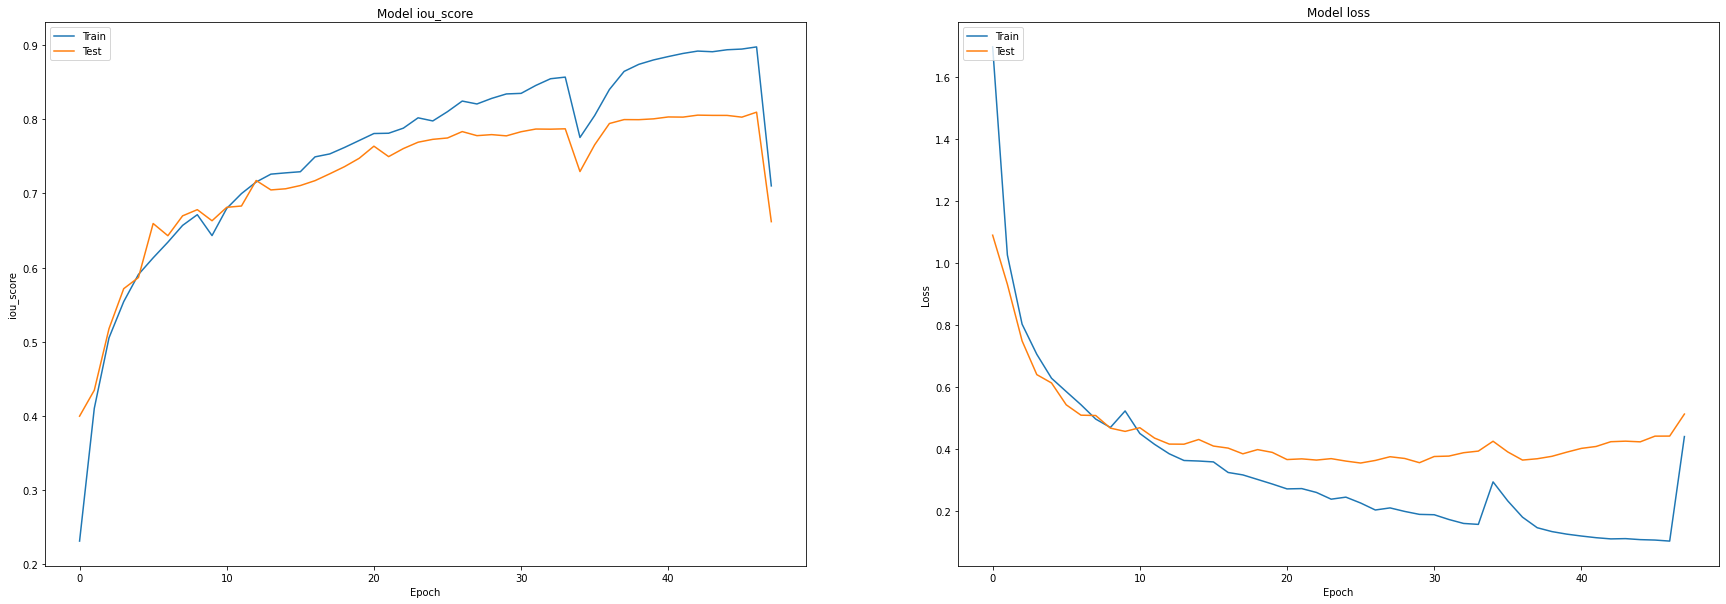

In [65]:
plt.figure(figsize=(30, 10))
plt.subplot(121)
plt.plot(hist.history['iou_coef'])
plt.plot(hist.history['val_iou_coef'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'predicted labels')

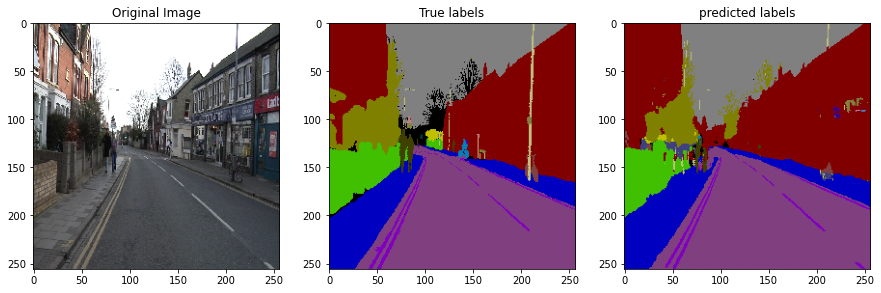

In [66]:
plt.figure(figsize=(15,15))
plt.subplot(131);plt.title('Original Image')
plt.imshow(img/255.)
plt.subplot(132);plt.title('True labels')
plt.imshow(gt_img/255.)
plt.subplot(133)
plt.imshow(pred_colored/255.);plt.title('predicted labels')